<a href="https://colab.research.google.com/github/MikeSirya/Master-Thesis/blob/main/LSTM_Hold_Out_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import tensorflow as tf
import os
import numpy as np

import  tensorflow.keras.losses

In [ ]:
# Specify the path to the CSV file with station codes
csv_path = "/content/Forcall.csv"

df = pd.read_csv(csv_path)
df

,Timestamp,Forcall
0,01/01/2021 00:00,1.7
1,01/01/2021 00:10,0.9
2,01/01/2021 00:20,0.7
3,01/01/2021 00:30,0.4
4,01/01/2021 00:40,0.1
...,...,...
21739,31/05/2021 23:10,15.7
21740,31/05/2021 23:20,15.6
21741,31/05/2021 23:30,15.4
21742,31/05/2021 23:40,15.4


In [ ]:
df.index = pd.to_datetime(df['Timestamp'], format= "%d/%m/%Y %H:%M")
df[:5]

,Timestamp,Forcall
Timestamp,,
2021-01-01 00:00:00,01/01/2021 00:00,1.7
2021-01-01 00:10:00,01/01/2021 00:10,0.9
2021-01-01 00:20:00,01/01/2021 00:20,0.7
2021-01-01 00:30:00,01/01/2021 00:30,0.4
2021-01-01 00:40:00,01/01/2021 00:40,0.1


<Axes: xlabel='Timestamp'>

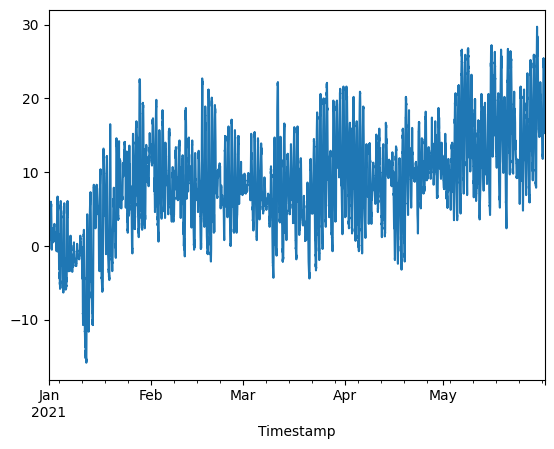

In [ ]:
temp = df['Forcall']
temp.plot()

In [ ]:
# [[[1], [2], [3], [4], [5]]] [6]
# [[[2], [3], [4], [5], [6]]] [7]
# [[[3], [4], [5], [6], [7]]] [8]

def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [ ]:
WINDOW_SIZE = 5
X1, y1 = df_to_X_y(temp, WINDOW_SIZE)
X1.shape, y1.shape

((21739, 5, 1), (21739,))

In [ ]:
X_train1, y_train1 = X1[:6000], y1[:6000]
X_val1, y_val1 = X1[6000:6500], y1[6000:6500]
X_test1, y_test1 = X1[6500:15000], y1[6500:15000]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((6000, 5, 1), (6000,), (500, 5, 1), (500,), (8500, 5, 1), (8500,))

In [ ]:
from tensorflow.keras import losses
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam



model3 = Sequential()
model3.add(InputLayer((5, 1)))
model3.add(LSTM(64))
model3.add(Dense(8, 'relu'))
model3.add(Dense(1, 'linear'))

model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17425 (68.07 KB)
Trainable params: 17425 (68.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
cp1 = ModelCheckpoint('model3/', save_best_only=True)
model3.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [ ]:
model3.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=10, callbacks=[cp1])

Epoch 1/10
188/188 [==============================] - 8s 30ms/step - loss: 58.1922 - root_mean_squared_error: 7.6284 - val_loss: 54.8967 - val_root_mean_squared_error: 7.4092
Epoch 2/10
188/188 [==============================] - 5s 26ms/step - loss: 37.6407 - root_mean_squared_error: 6.1352 - val_loss: 29.0637 - val_root_mean_squared_error: 5.3911
Epoch 3/10
188/188 [==============================] - 5s 25ms/step - loss: 21.9354 - root_mean_squared_error: 4.6835 - val_loss: 14.4786 - val_root_mean_squared_error: 3.8051
Epoch 4/10
188/188 [==============================] - 6s 33ms/step - loss: 14.0712 - root_mean_squared_error: 3.7512 - val_loss: 8.3514 - val_root_mean_squared_error: 2.8899
Epoch 5/10
188/188 [==============================] - 4s 23ms/step - loss: 9.4703 - root_mean_squared_error: 3.0774 - val_loss: 4.8608 - val_root_mean_squared_error: 2.2047
Epoch 6/10
188/188 [==============================] - 6s 31ms/step - loss: 6.3763 - root_mean_squared_error: 2.5251 - val_loss: 

In [ ]:
from tensorflow.keras.models import load_model
model3 = load_model('model3/')

In [ ]:
from math import sqrt
from sklearn.metrics import mean_squared_error
train_predictions = model3.predict(X_train1).flatten()
rmse = sqrt(mean_squared_error(y_train1, train_predictions))
train_results = pd.DataFrame(data={'Actuals':y_train1,'Train Predictions':train_predictions, 'RMSE': [rmse] * len(y_train1)})
train_results

188/188 [==============================] - 1s 2ms/step


,Actuals,Train Predictions,RMSE
0,-0.3,-0.132902,1.216588
1,-0.4,-0.351222,1.216588
2,-0.4,-0.651093,1.216588
3,-0.3,-0.752964,1.216588
4,0.0,-0.671733,1.216588
...,...,...,...
5995,18.7,13.474446,1.216588
5996,18.5,13.482484,1.216588
5997,18.3,13.482965,1.216588
5998,17.8,13.480849,1.216588


Text(0.5, 1.0, 'HOLDOUT LSTM MODEL 3')

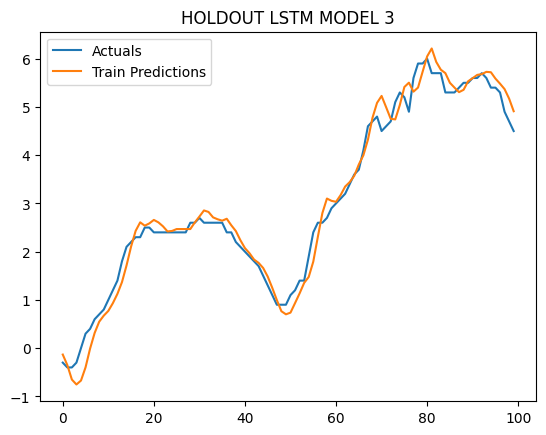

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_results['Actuals'][:100], label='Actuals')
plt.plot(train_results['Train Predictions'][:100], label='Train Predictions')
plt.legend()
plt.title('HOLDOUT LSTM MODEL 3')

In [ ]:
val_predictions = model3.predict(X_val1).flatten()
rmse = sqrt(mean_squared_error(y_val1, val_predictions))
val_results = pd.DataFrame(data={ 'Actuals':y_val1, 'Val Predictions':val_predictions, 'RMSE': [rmse] * len(y_val1)})
val_results

16/16 [==============================] - 0s 3ms/step


,Actuals,Val Predictions,RMSE
0,16.9,13.471487,0.680205
1,17.2,13.462366,0.680205
2,17.6,13.461892,0.680205
3,17.5,13.467228,0.680205
4,16.9,13.468416,0.680205
...,...,...,...
495,7.6,7.407412,0.680205
496,7.7,7.522288,0.680205
497,7.7,7.629782,0.680205
498,7.7,7.691550,0.680205


Text(0.5, 1.0, 'HOLDOUT LSTM MODEL 3')

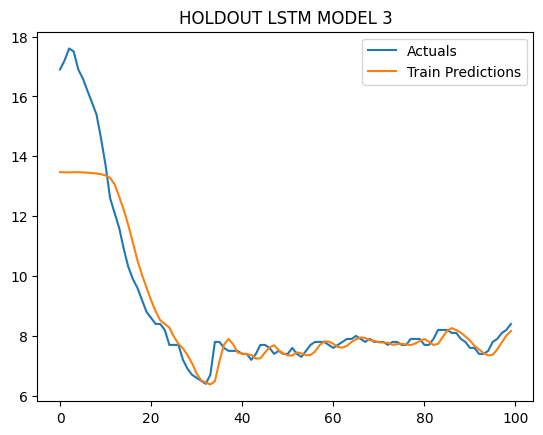

In [ ]:
plt.plot(val_results['Actuals'][:100], label='Actuals')
plt.plot(val_results['Val Predictions'][:100],label='Train Predictions' )

plt.legend()
plt.title('HOLDOUT LSTM MODEL 3')

In [ ]:
test_predictions = model3.predict(X_test1).flatten()
rmse = sqrt(mean_squared_error(y_test1, test_predictions))
test_results = pd.DataFrame(data={ 'Actuals':y_test1, 'Test Predictions':test_predictions, 'RMSE': [rmse] * len(y_test1)})

test_results

266/266 [==============================] - 2s 6ms/step


,Actuals,Test Predictions,RMSE
0,7.6,7.629688,1.858646
1,7.5,7.572567,1.858646
2,7.4,7.497439,1.858646
3,7.2,7.404897,1.858646
4,7.2,7.257933,1.858646
...,...,...,...
8495,9.1,8.959905,1.858646
8496,9.1,9.083035,1.858646
8497,9.1,9.168649,1.858646
8498,9.1,9.225438,1.858646


Text(0.5, 1.0, 'HOLDOUT LSTM MODEL 3')

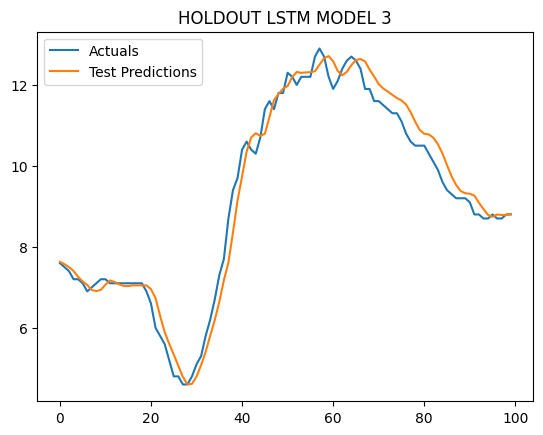

In [ ]:
plt.plot(test_results['Actuals'][:100], label='Actuals')
plt.plot(test_results['Test Predictions'][:100],label='Test Predictions' )

plt.legend()
plt.title('HOLDOUT LSTM MODEL 3')

In [ ]:
# Specify the path to the CSV file with station codes
csv_path = "/content/Forcall22.csv"

val_df = pd.read_csv(csv_path)
val_df

,Timestamp,Forcall
0,01/01/2021 00:00,2.8
1,01/01/2021 00:10,2.3
2,01/01/2021 00:20,2.2
3,01/01/2021 00:30,2.4
4,01/01/2021 00:40,2.5
...,...,...
21739,31/05/2021 23:10,17.6
21740,31/05/2021 23:20,17.3
21741,31/05/2021 23:30,17.1
21742,31/05/2021 23:40,16.9


In [ ]:
val_df.index = pd.to_datetime(val_df['Timestamp'], format= "%d/%m/%Y %H:%M")
val_df[:5]

,Timestamp,Forcall
Timestamp,,
2021-01-01 00:00:00,01/01/2021 00:00,2.8
2021-01-01 00:10:00,01/01/2021 00:10,2.3
2021-01-01 00:20:00,01/01/2021 00:20,2.2
2021-01-01 00:30:00,01/01/2021 00:30,2.4
2021-01-01 00:40:00,01/01/2021 00:40,2.5


<Axes: xlabel='Timestamp'>

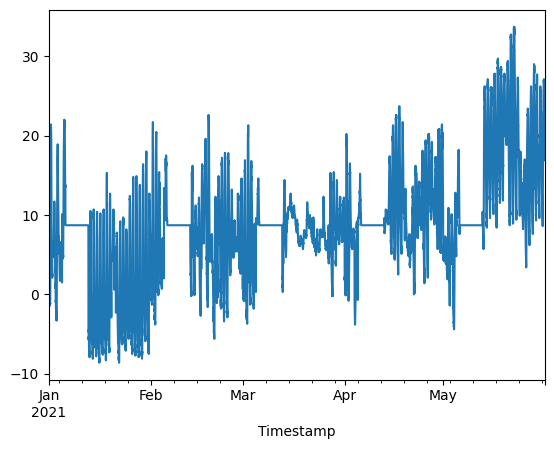

In [ ]:
val_df = val_df['Forcall']
val_df.plot()

In [ ]:
WINDOW_SIZE = 5
X2, y2 = df_to_X_y(val_df, WINDOW_SIZE)
X2.shape, y2.shape

((21739, 5, 1), (21739,))

In [ ]:
X_New, y_New = X2[6000:15000], y2[6000:15000]
X_New.shape, y_New.shape

((9000, 5, 1), (9000,))

In [ ]:
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error
import pandas as pd

# Assuming you have already defined model1, X_New, and y_New

# Make predictions on the new data
train_predictions = model3.predict(X_New).flatten()

# Check for NaN values in y_New and train_predictions
nan_mask = np.isnan(y_New) | np.isnan(train_predictions)

# Remove rows with NaN values
y_New_cleaned = y_New[~nan_mask]
train_predictions_cleaned = train_predictions[~nan_mask]

# Check again for NaN values after removal
if np.isnan(y_New_cleaned).any() or np.isnan(train_predictions_cleaned).any():
    raise ValueError("NaN values still present after removal.")

# Calculate the Root Mean Squared Error (RMSE)
rmse1 = sqrt(mean_squared_error(y_New_cleaned, train_predictions_cleaned))

# Create a DataFrame with the results
train_results1 = pd.DataFrame(data={'Train Predictions': train_predictions_cleaned, 'Actuals': y_New_cleaned, 'RMSE': [rmse1] * len(y_New_cleaned)})

# Specify the path where you want to save the CSV file
#csv_file_path = 'Castellon Bayanat 2022 C2.csv'

# Save the DataFrame to a CSV file
#train_results1.to_csv(csv_file_path, index=False)
1.227238
#print(f'DataFrame has been saved to {csv_file_path}')
# Print or further analyze the results
print(train_results1)

282/282 [==============================] - 1s 2ms/step
      Train Predictions   Actuals      RMSE
0              8.766041  8.707953  1.047443
1              8.766041  8.707953  1.047443
2              8.766041  8.707953  1.047443
3              8.766041  8.707953  1.047443
4              8.766041  8.707953  1.047443
...                 ...       ...       ...
8995           5.987952  5.700000  1.047443
8996           5.836887  5.400000  1.047443
8997           5.576391  5.200000  1.047443
8998           5.321750  5.300000  1.047443
8999           5.251984  5.400000  1.047443

[9000 rows x 3 columns]


Text(0.5, 1.0, 'HOLDOUT LSTM MODEL 3')

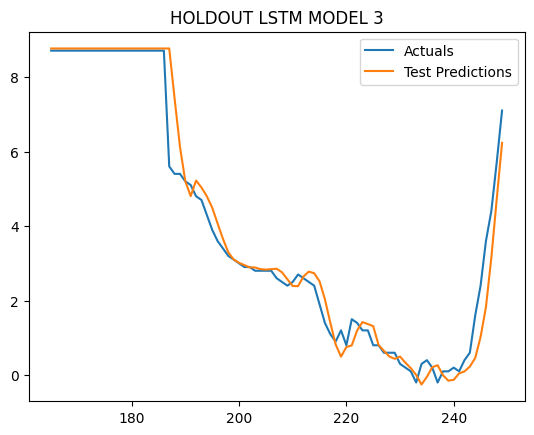

In [ ]:
plt.plot(train_results1['Actuals'][165:250], label='Actuals')
plt.plot(train_results1['Train Predictions'][165:250],label='Test Predictions' )

plt.legend()
plt.title('HOLDOUT LSTM MODEL 3')

In [ ]:
# Specify the path to the CSV file with station codes
csv_path = "/content/Cati22.csv"

val_df2 = pd.read_csv(csv_path)
val_df2

,Timestamp,Catí
0,01/01/2021 00:00,9.80
1,01/01/2021 00:10,9.40
2,01/01/2021 00:20,9.40
3,01/01/2021 00:30,9.30
4,01/01/2021 00:40,9.30
...,...,...
21739,31/05/2021 23:10,17.20
21740,31/05/2021 23:20,17.00
21741,31/05/2021 23:30,16.80
21742,31/05/2021 23:40,16.50


In [ ]:
val_df2.index = pd.to_datetime(val_df2['Timestamp'], format= "%d/%m/%Y %H:%M")
val_df2[:5]

,Timestamp,Catí
Timestamp,,
2021-01-01 00:00:00,01/01/2021 00:00,9.8
2021-01-01 00:10:00,01/01/2021 00:10,9.4
2021-01-01 00:20:00,01/01/2021 00:20,9.4
2021-01-01 00:30:00,01/01/2021 00:30,9.3
2021-01-01 00:40:00,01/01/2021 00:40,9.3


<Axes: xlabel='Timestamp'>

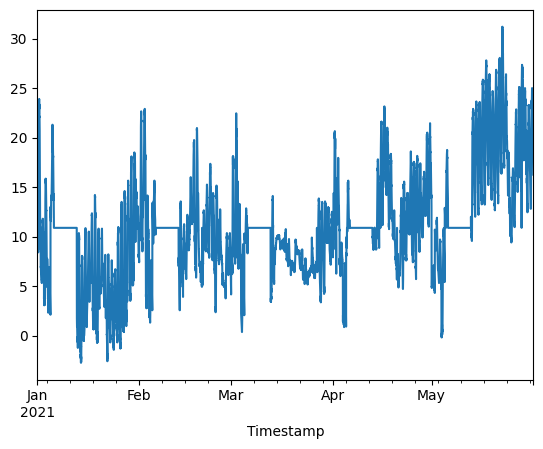

In [ ]:
val_df2 = val_df2['Catí']
val_df2.plot()

In [ ]:
WINDOW_SIZE = 5
X3, y3 = df_to_X_y(val_df2, WINDOW_SIZE)
X2.shape, y2.shape

((21739, 5, 1), (21739,))

In [ ]:
X_New2, y_New2 = X3[6000:15000], y3[6000:15000]
X_New2.shape, y_New2.shape

((9000, 5, 1), (9000,))

In [ ]:
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error
import pandas as pd

# Assuming you have already defined model1, X_New, and y_New

# Make predictions on the new data
train_predictions2 = model3.predict(X_New2).flatten()

# Check for NaN values in y_New and train_predictions
nan_mask = np.isnan(y_New2) | np.isnan(train_predictions2)

# Remove rows with NaN values
y_New_cleaned2 = y_New2[~nan_mask]
train_predictions_cleaned2 = train_predictions2[~nan_mask]

# Check again for NaN values after removal
if np.isnan(y_New_cleaned2).any() or np.isnan(train_predictions_cleaned2).any():
    raise ValueError("NaN values still present after removal.")

# Calculate the Root Mean Squared Error (RMSE)
rmse2 = sqrt(mean_squared_error(y_New_cleaned2, train_predictions_cleaned2))

# Create a DataFrame with the results
train_results2 = pd.DataFrame(data={'Train Predictions': train_predictions_cleaned2, 'Actuals': y_New_cleaned2, 'RMSE': [rmse2] * len(y_New_cleaned2)})

# Specify the path where you want to save the CSV file
##csv_file_path = 'Benicassim2022 C2.csv'

# Save the DataFrame to a CSV file
#train_results2.to_csv(csv_file_path, index=False)

#print(f'DataFrame has been saved to {csv_file_path}')
# Print or further analyze the results
print(train_results2)

282/282 [==============================] - 1s 2ms/step
      Train Predictions    Actuals      RMSE
0             11.187020  10.877977  1.046936
1             11.187020  10.877977  1.046936
2             11.187020  10.877977  1.046936
3             11.187020  10.877977  1.046936
4             11.187020  10.877977  1.046936
...                 ...        ...       ...
8995          12.619908  12.350000  1.046936
8996          12.549617  12.400000  1.046936
8997          12.492561  12.700000  1.046936
8998          12.560299  12.600000  1.046936
8999          12.607344  12.500000  1.046936

[9000 rows x 3 columns]


Text(0.5, 1.0, 'HOLDOUT LSTM MODEL 3')

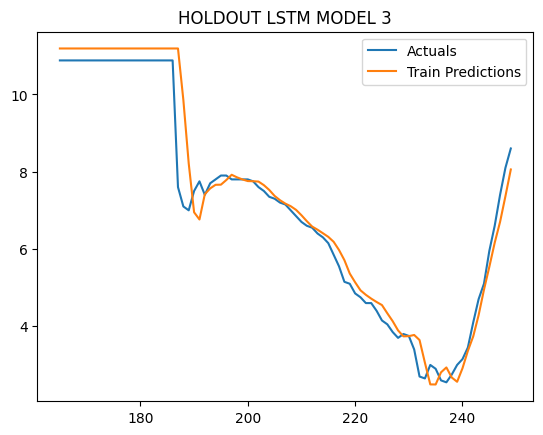

In [ ]:
plt.plot(train_results2['Actuals'][165:250], label='Actuals')
plt.plot(train_results2['Train Predictions'][165:250],label='Train Predictions' )

plt.legend()
plt.title('HOLDOUT LSTM MODEL 3')

In [ ]:
# Specify the path to the CSV file with station codes
csv_path = "/content/Xodos22.csv"

val_df3 = pd.read_csv(csv_path)
val_df3

,Timestamp,Xodos
0,01/01/2021 00:00,16.4
1,01/01/2021 00:10,16.7
2,01/01/2021 00:20,17.1
3,01/01/2021 00:30,17.2
4,01/01/2021 00:40,17.2
...,...,...
21739,31/05/2021 23:10,17.7
21740,31/05/2021 23:20,17.7
21741,31/05/2021 23:30,18.0
21742,31/05/2021 23:40,17.9


In [ ]:
val_df3.index = pd.to_datetime(val_df3['Timestamp'], format= "%d/%m/%Y %H:%M")
val_df3[:10]

,Timestamp,Xodos
Timestamp,,
2021-01-01 00:00:00,01/01/2021 00:00,16.4
2021-01-01 00:10:00,01/01/2021 00:10,16.7
2021-01-01 00:20:00,01/01/2021 00:20,17.1
2021-01-01 00:30:00,01/01/2021 00:30,17.2
2021-01-01 00:40:00,01/01/2021 00:40,17.2
2021-01-01 00:50:00,01/01/2021 00:50,17.1
2021-01-01 01:00:00,01/01/2021 01:00,16.9
2021-01-01 01:10:00,01/01/2021 01:10,17.2
2021-01-01 01:20:00,01/01/2021 01:20,17.4


<Axes: xlabel='Timestamp'>

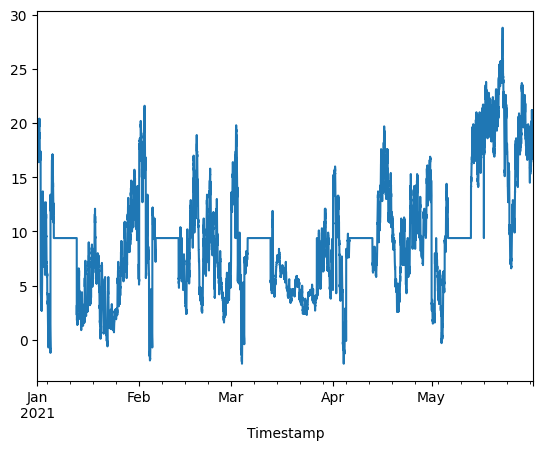

In [ ]:
val_df3 = val_df3['Xodos']
val_df3.plot()

In [ ]:
WINDOW_SIZE = 5
X4, y4 = df_to_X_y(val_df3, WINDOW_SIZE)
X4.shape, y4.shape

((21739, 5, 1), (21739,))

In [ ]:
X_New3, y_New3 = X4[:8754], y4[:8754]
X_New3.shape, y_New3.shape

((8754, 5, 1), (8754,))

In [ ]:
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error
import pandas as pd

# Assuming you have already defined model1, X_New, and y_New

# Make predictions on the new data
train_predictions3 = model3.predict(X_New3).flatten()

# Check for NaN values in y_New and train_predictions
nan_mask = np.isnan(y_New3) | np.isnan(train_predictions3)

# Remove rows with NaN values
y_New_cleaned3 = y_New3[~nan_mask]
train_predictions_cleaned3 = train_predictions3[~nan_mask]

# Check again for NaN values after removal
if np.isnan(y_New_cleaned3).any() or np.isnan(train_predictions_cleaned3).any():
    raise ValueError("NaN values still present after removal.")

# Calculate the Root Mean Squared Error (RMSE)
rmse3 = sqrt(mean_squared_error(y_New_cleaned3, train_predictions_cleaned3))

# Create a DataFrame with the results
train_results3 = pd.DataFrame(data={'Train Predictions': train_predictions_cleaned3, 'Actuals': y_New_cleaned3, 'RMSE': [rmse3] * len(y_New_cleaned3)})

# Specify the path where you want to save the CSV file
#csv_file_path = 'La vadalbla centre2022 C4.csv'

# Save the DataFrame to a CSV file
#train_results3.to_csv(csv_file_path, index=False)

#print(f'DataFrame has been saved to {csv_file_path}')
# Print or further analyze the results
print(train_results3)

274/274 [==============================] - 1s 2ms/step
      Train Predictions  Actuals      RMSE
0             13.459451     17.1  1.272555
1             13.459188     16.9  1.272555
2             13.456550     17.2  1.272555
3             13.459044     17.4  1.272555
4             13.463506     17.2  1.272555
...                 ...      ...       ...
8749          13.341084     14.7  1.272555
8750          13.326990     14.3  1.272555
8751          13.299004     14.4  1.272555
8752          13.284250     14.6  1.272555
8753          13.290617     14.4  1.272555

[8754 rows x 3 columns]


Text(0.5, 1.0, 'HOLDOUT LSTM MODEL 3')

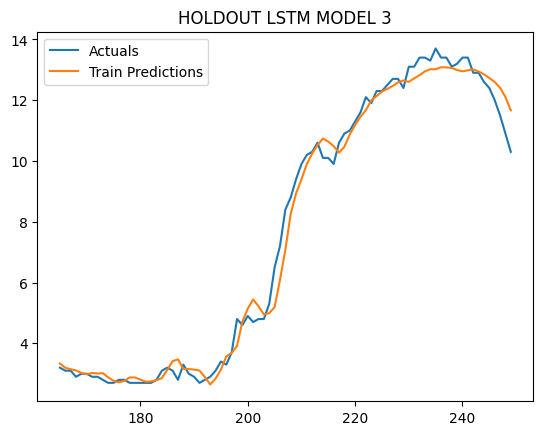

In [ ]:
plt.plot(train_results3['Actuals'][165:250], label='Actuals')
plt.plot(train_results3['Train Predictions'][165:250],label='Train Predictions' )

plt.legend()
plt.title('HOLDOUT LSTM MODEL 3')

In [ ]:
# Specify the path to the CSV file with station codes
csv_path = "/content/Castellon Bayanat22.csv"

val_df4 = pd.read_csv(csv_path)
val_df4

,Timestamp,Castelló de la Plana - IES Vicent Sos Baynat
0,01/01/2021 00:00,9.7
1,01/01/2021 00:10,9.5
2,01/01/2021 00:20,9.3
3,01/01/2021 00:30,9.3
4,01/01/2021 00:40,9.1
...,...,...
21739,31/05/2021 23:10,21.3
21740,31/05/2021 23:20,21.2
21741,31/05/2021 23:30,21.2
21742,31/05/2021 23:40,21.3


In [ ]:
val_df4.index = pd.to_datetime(val_df4['Timestamp'], format= "%d/%m/%Y %H:%M")
val_df4[:10]

,Timestamp,Castelló de la Plana - IES Vicent Sos Baynat
Timestamp,,
2021-01-01 00:00:00,01/01/2021 00:00,9.7
2021-01-01 00:10:00,01/01/2021 00:10,9.5
2021-01-01 00:20:00,01/01/2021 00:20,9.3
2021-01-01 00:30:00,01/01/2021 00:30,9.3
2021-01-01 00:40:00,01/01/2021 00:40,9.1
2021-01-01 00:50:00,01/01/2021 00:50,8.8
2021-01-01 01:00:00,01/01/2021 01:00,8.4
2021-01-01 01:10:00,01/01/2021 01:10,8.1
2021-01-01 01:20:00,01/01/2021 01:20,8.2


<Axes: xlabel='Timestamp'>

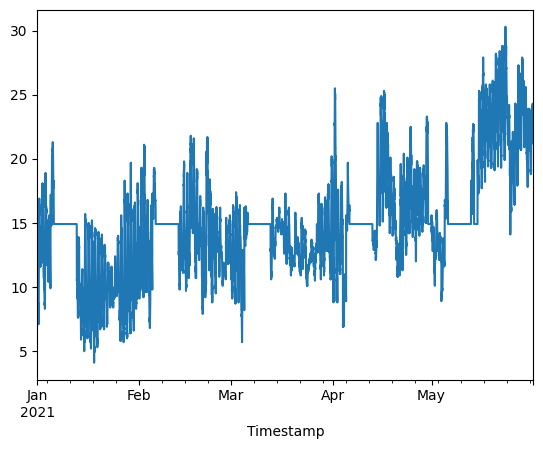

In [ ]:
val_df4 = val_df4['Castelló de la Plana - IES Vicent Sos Baynat']
val_df4.plot()

In [ ]:
WINDOW_SIZE = 5
X5, y5 = df_to_X_y(val_df4, WINDOW_SIZE)
X5.shape, y5.shape

((21739, 5, 1), (21739,))

In [ ]:
X_New4, y_New4 = X5[:8754], y5[:8754]
X_New4.shape, y_New4.shape

((8754, 5, 1), (8754,))

In [ ]:
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error
import pandas as pd

# Assuming you have already defined model1, X_New, and y_New

# Make predictions on the new data
train_predictions4 = model3.predict(X_New4).flatten()

# Check for NaN values in y_New and train_predictions
nan_mask = np.isnan(y_New4) | np.isnan(train_predictions4)

# Remove rows with NaN values
y_New_cleaned4 = y_New4[~nan_mask]
train_predictions_cleaned4 = train_predictions4[~nan_mask]

# Check again for NaN values after removal
if np.isnan(y_New_cleaned4).any() or np.isnan(train_predictions_cleaned4).any():
    raise ValueError("NaN values still present after removal.")

# Calculate the Root Mean Squared Error (RMSE)
rmse4 = sqrt(mean_squared_error(y_New_cleaned4, train_predictions_cleaned4))

# Create a DataFrame with the results
train_results4 = pd.DataFrame(data={'Train Predictions': train_predictions_cleaned4, 'Actuals': y_New_cleaned4, 'RMSE': [rmse4] * len(y_New_cleaned4)})

# Specify the path where you want to save the CSV file
#csv_file_path = 'La Torre den Besora -esportiva2022 C3.csv'

# Save the DataFrame to a CSV file
#train_results4.to_csv(csv_file_path, index=False)

#print(f'DataFrame has been saved to {csv_file_path}')
# Print or further analyze the results
print(train_results4)

274/274 [==============================] - 1s 4ms/step
      Train Predictions  Actuals      RMSE
0              9.314478      8.8  1.848148
1              9.093163      8.4  1.848148
2              8.736539      8.1  1.848148
3              8.323328      8.2  1.848148
4              8.132164      8.3  1.848148
...                 ...      ...       ...
8749          13.141174     13.3  1.848148
8750          13.064216     13.3  1.848148
8751          13.016711     13.3  1.848148
8752          12.995895     13.3  1.848148
8753          12.992953     13.2  1.848148

[8754 rows x 3 columns]


Text(0.5, 1.0, 'HOLDOUT LSTM MODEL 3')

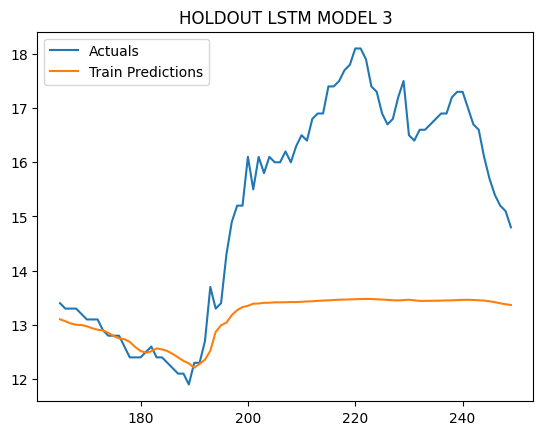

In [ ]:
plt.plot(train_results4['Actuals'][165:250], label='Actuals')
plt.plot(train_results4['Train Predictions'][165:250],label='Train Predictions' )

plt.legend()
plt.title('HOLDOUT LSTM MODEL 3')

In [ ]:
# Specify the path to the CSV file with station codes
csv_path = "/content/SantMateu22.csv"

val_df5 = pd.read_csv(csv_path)
val_df5

,Timestamp,Sant Mateu
0,01/01/2021 00:00,6.15
1,01/01/2021 00:10,6.70
2,01/01/2021 00:20,6.85
3,01/01/2021 00:30,6.65
4,01/01/2021 00:40,6.55
...,...,...
21739,31/05/2021 23:10,17.75
21740,31/05/2021 23:20,17.80
21741,31/05/2021 23:30,17.70
21742,31/05/2021 23:40,16.45


In [ ]:
val_df5.index = pd.to_datetime(val_df5['Timestamp'], format= "%d/%m/%Y %H:%M")
val_df5[:5]

,Timestamp,Sant Mateu
Timestamp,,
2021-01-01 00:00:00,01/01/2021 00:00,6.15
2021-01-01 00:10:00,01/01/2021 00:10,6.70
2021-01-01 00:20:00,01/01/2021 00:20,6.85
2021-01-01 00:30:00,01/01/2021 00:30,6.65
2021-01-01 00:40:00,01/01/2021 00:40,6.55


<Axes: xlabel='Timestamp'>

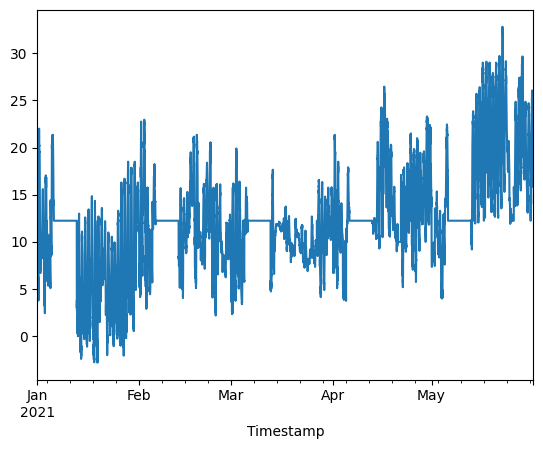

In [ ]:
val_df5 = val_df5['Sant Mateu']
val_df5.plot()

In [ ]:
WINDOW_SIZE = 5
X6, y6 = df_to_X_y(val_df5, WINDOW_SIZE)
X6.shape, y6.shape

((21739, 5, 1), (21739,))

In [ ]:
X_New5, y_New5 = X6[:8754], y6[:8754]
X_New5.shape, y_New5.shape

((8754, 5, 1), (8754,))

In [ ]:
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error
import pandas as pd

# Assuming you have already defined model1, X_New, and y_New

# Make predictions on the new data
train_predictions5 = model3.predict(X_New5).flatten()

# Check for NaN values in y_New and train_predictions
nan_mask = np.isnan(y_New5) | np.isnan(train_predictions5)

# Remove rows with NaN values
y_New_cleaned5 = y_New5[~nan_mask]
train_predictions_cleaned5 = train_predictions5[~nan_mask]

# Check again for NaN values after removal
if np.isnan(y_New_cleaned5).any() or np.isnan(train_predictions_cleaned5).any():
    raise ValueError("NaN values still present after removal.")

# Calculate the Root Mean Squared Error (RMSE)
rmse5 = sqrt(mean_squared_error(y_New_cleaned5, train_predictions_cleaned5))

# Create a DataFrame with the results
train_results5 = pd.DataFrame(data={'Train Predictions': train_predictions_cleaned5, 'Actuals': y_New_cleaned5, 'RMSE': [rmse5] * len(y_New_cleaned5)})

# Specify the path where you want to save the CSV file
#csv_file_path = 'Olocau del Rei2022 C5.csv'

# Save the DataFrame to a CSV file
#train_results5.to_csv(csv_file_path, index=False)

#print(f'DataFrame has been saved to {csv_file_path}')
# Print or further analyze the results
print(train_results5)

274/274 [==============================] - 1s 2ms/step
      Train Predictions  Actuals     RMSE
0              6.710260     6.20  1.65387
1              6.357952     6.35  1.65387
2              6.233768     6.15  1.65387
3              6.146484     6.10  1.65387
4              6.094568     6.30  1.65387
...                 ...      ...      ...
8749          13.177656    11.90  1.65387
8750          12.638442    11.15  1.65387
8751          11.979427    10.80  1.65387
8752          11.425363    10.20  1.65387
8753          10.916797    10.05  1.65387

[8754 rows x 3 columns]


Text(0.5, 1.0, 'HOLDOUT LSTM MODEL 3')

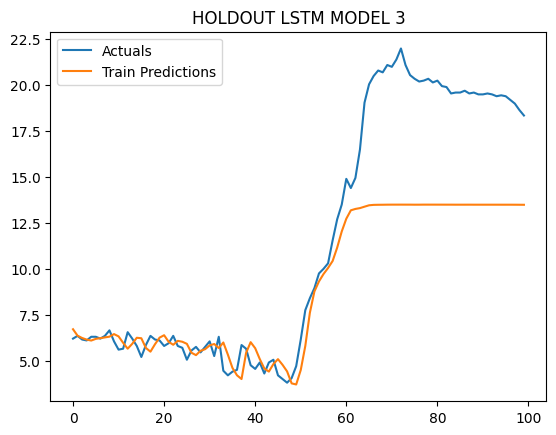

In [ ]:
plt.plot(train_results5['Actuals'][:100], label='Actuals')
plt.plot(train_results5['Train Predictions'][:100],label='Train Predictions' )

plt.legend()
plt.title('HOLDOUT LSTM MODEL 3')